# Case Study - Analysis and prediction of the monthly sales of a certain store. The provided data ranges from 2013 to 2017.


### In this session, we will build different predictive models on the training set, and check their accuracy on test set. We then pick the best-performing model on the test data as the optimal model.

## Importing Necessary Packages



In [ ]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import seaborn as sns

# Time series analysis and forecasting libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from calendar import month_abbr

# Setting the background theme and font scale for figures
sns.set_theme(style = 'darkgrid', font_scale = 1.15)
# To restrict the float value to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Auxiliary Functions

In [ ]:
# Converting month names to their abbrevations
def month_abbrev(month):
    return str(month)[0:3]

# Reprting the MAPE score
def MAPE(y_truth, y_pred):
    mape = 0
    for i in range(len(y_truth)):
        mape += np.abs(y_truth[i] - y_pred[i])/np.abs(y_truth[i])*100
    mape = mape/len(y_truth)
    return mape

# Reporting the mean absolute deviation score
def MAD(y_truth, y_pred):
    return mean_absolute_error(y_truth, y_pred)

# Reporting the RMSE score
def RMSE(y_truth, y_pred):
    return np.sqrt(mean_squared_error(y_truth, y_pred))

## Reading the Dataset

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Python_files/Monthly_Sales.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Viewing the first and last few rows of the dataset
print('The top 5 rows:')
display(df.head())
print('\nThe bottom 5 rows:')
display(df.tail())

The top 5 rows:


,Month,Sales
0,Jan-13,454904
1,Feb-13,459417
2,Mar-13,617382
3,Apr-13,682274
4,May-13,763242



The bottom 5 rows:


,Month,Sales
55,Aug-17,1026403
56,Sep-17,935263
57,Oct-17,891160
58,Nov-17,928837
59,Dec-17,695170


In [ ]:
# Changing the name of columns
df.rename(columns = {'Month': 'Date'}, inplace = True)

# Generating a timestamp and setting it as an index
df['Date'] = pd.to_datetime(df['Date'], format = '%b-%y')
df.set_index(keys = 'Date', inplace = True)

# Separating month and year columns separately
df['Year'] = df.index.year
df['Month'] = df.index.month_name()
df['Month'] = df['Month'].apply(month_abbrev) 
df.head()

,Sales,Year,Month
Date,,,
2013-01-01,454904,2013,Jan
2013-02-01,459417,2013,Feb
2013-03-01,617382,2013,Mar
2013-04-01,682274,2013,Apr
2013-05-01,763242,2013,May


## Exploratory Data Analysis

### Statistical Description

In [ ]:
# Let's convert year and month into categorical variables
df['Year'] = pd.Categorical(df['Year'])
df['Month'] = pd.Categorical(df['Month'])

In [ ]:
# Numerical variables
print('Statistical summary of numerical variables:')
display(df.describe(include = np.number).T)

# Categorical variables
print('\nStatistical summary of categorical variables:')
display(df.describe(include = 'category').T)

Statistical summary of numerical variables:


,count,mean,std,min,25%,50%,75%,max
Sales,60.00,795075.20,172901.78,454904.00,661705.00,799018.00,922026.25,1171393.00



Statistical summary of categorical variables:


,count,unique,top,freq
Year,60,5,2013,12
Month,60,12,Apr,5


In [ ]:
# Converting year back into an integer
df['Year'] = df['Year'].astype(int)
# Checking data tyes
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2013-01-01 to 2017-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Sales   60 non-null     int64   
 1   Year    60 non-null     int64   
 2   Month   60 non-null     category
dtypes: category(1), int64(2)
memory usage: 1.9 KB


### Plotting the Time Series Along With Mean and Median




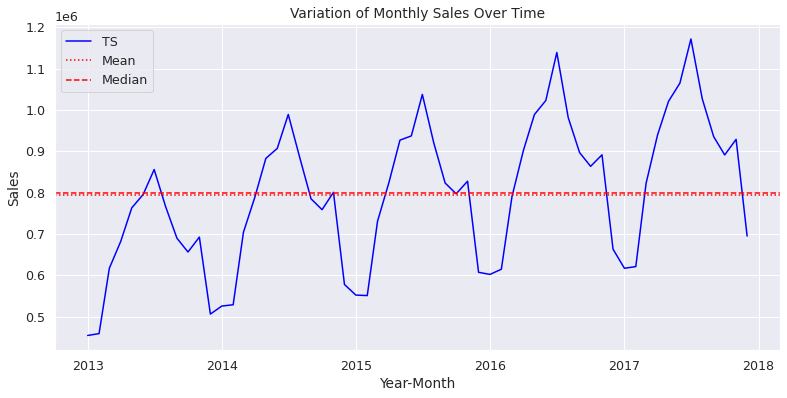

In [ ]:
plt.figure(figsize = (13, 6));
plt.plot(df.index, df.Sales, color = 'blue');
plt.axhline(df.Sales.mean(), color = 'red', linestyle = ':');
plt.axhline(df.Sales.median(), color = 'red', linestyle = '--');
plt.legend(['TS', 'Mean', 'Median'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Variation of Monthly Sales Over Time');

### Annual Distribution of Sales

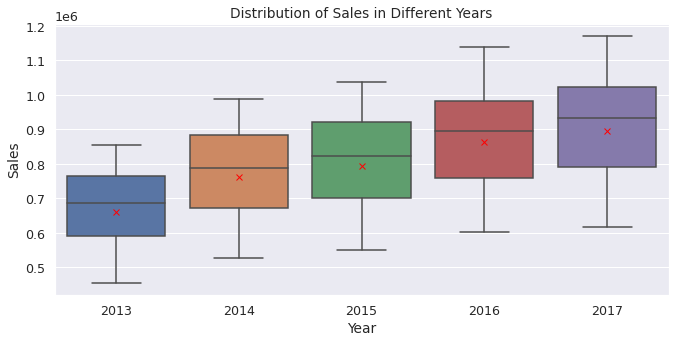

In [ ]:
plt.figure(figsize = (11, 5));
sns.boxplot(data = df, x = 'Year', y = 'Sales', showmeans = True, meanprops = 
            {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.title('Distribution of Sales in Different Years');

### Monthly Distribution of Sales

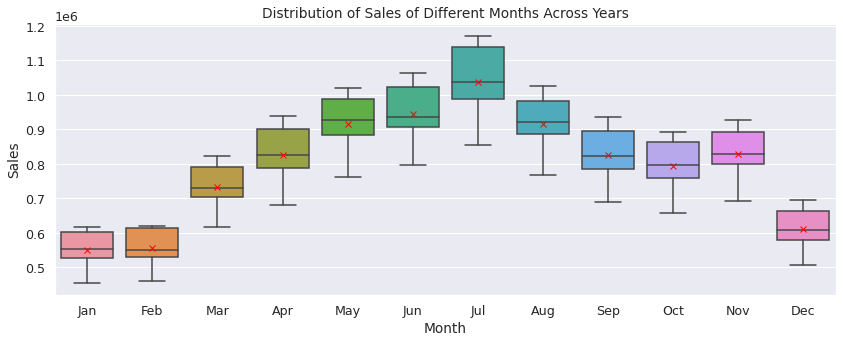

In [ ]:
plt.figure(figsize = (14, 5));
sns.boxplot(data = df, x = 'Month', y = 'Sales', showmeans = True, order = month_abbr[1:13],
            meanprops = {'marker': 'x', 'markerfacecolor': 'red', 'markeredgecolor': 'red', 'markersize': '5.5'});
plt.title('Distribution of Sales of Different Months Across Years');

### Monthly Sales Across Different Years 

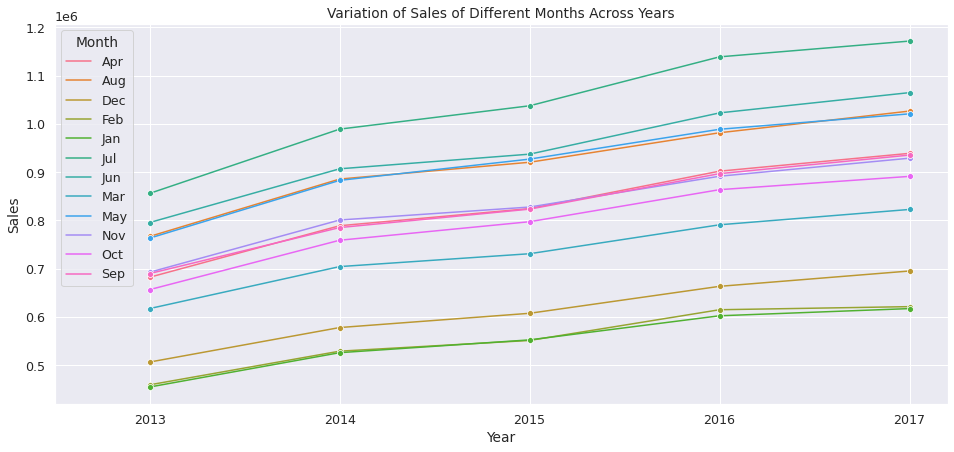

In [ ]:
plt.figure(figsize = (16, 7));
sns.lineplot(data = df, x = 'Year', y = 'Sales', hue = 'Month', marker = 'o', linewidth = 1.5);
plt.xticks(np.arange(2013, 2018));
plt.xlim(2012.5, 2017.2);
plt.title('Variation of Sales of Different Months Across Years');

### Time Series Decomposition

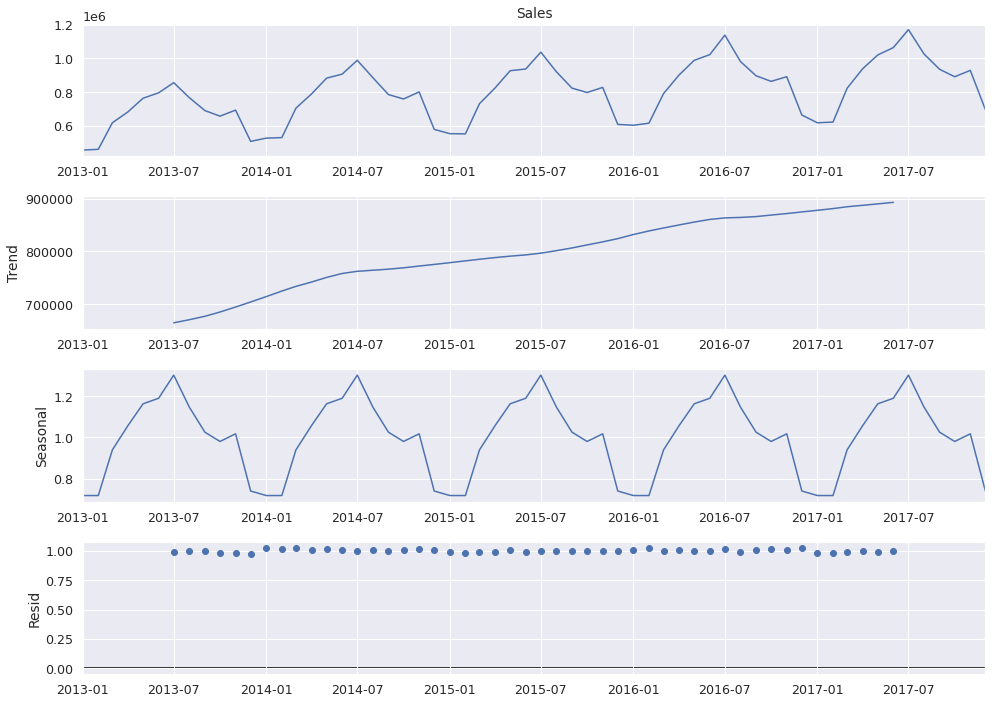

In [ ]:
from pylab import rcParams 
rcParams['figure.figsize'] = 14, 10
ts_decomposed = seasonal_decompose(df['Sales'], model = 'multiplicative')
ts_decomposed.plot();
plt.show();

## Time Series Forecasting

### Building Training and Test Sets

In [ ]:
train = df['Sales'].loc[df['Year'] < 2017]
test = df['Sales'].loc[df['Year'] >= 2017]

# Viewing the train and test sets
print('The first few rows of the training set:')
display(train.head(7))
print('\nThe first few rows of the test set:')
display(test.head(7))

# Shape of train and test sets
print('\nNo. of observations in the training set:', train.shape[0])
print('No. of observations in the test set:', test.shape[0])

The first few rows of the training set:


Date
2013-01-01    454904
2013-02-01    459417
2013-03-01    617382
2013-04-01    682274
2013-05-01    763242
2013-06-01    795597
2013-07-01    855922
Name: Sales, dtype: int64


The first few rows of the test set:


Date
2017-01-01     617306
2017-02-01     621369
2017-03-01     822667
2017-04-01     938862
2017-05-01    1020686
2017-06-01    1064624
2017-07-01    1171393
Name: Sales, dtype: int64


No. of observations in the training set: 48
No. of observations in the test set: 12


### Model 1: Linear Regression

In [ ]:
# Creating a separate train and test sets compatible with LinearRegression()
train_lr = pd.DataFrame(train.copy())
test_lr = pd.DataFrame(test.copy())
# Adding time instances to train and test sets
train_lr['Time'] = np.arange(0, train_lr.shape[0])
test_lr['Time'] = np.arange(train_lr.shape[0], train_lr.shape[0] + test_lr.shape[0])

# Viewing the train and test sets
print('The first few rows of the training set (for linear regression):')
display(train_lr.head(7))
print('\nThe first few rows of the test set (for linear regression):')
display(test_lr.head(7))

The first few rows of the training set (for linear regression):


,Sales,Time
Date,,
2013-01-01,454904,0
2013-02-01,459417,1
2013-03-01,617382,2
2013-04-01,682274,3
2013-05-01,763242,4
2013-06-01,795597,5
2013-07-01,855922,6



The first few rows of the test set (for linear regression):


,Sales,Time
Date,,
2017-01-01,617306,48
2017-02-01,621369,49
2017-03-01,822667,50
2017-04-01,938862,51
2017-05-01,1020686,52
2017-06-01,1064624,53
2017-07-01,1171393,54


In [ ]:
# Building the model
lr_model = LinearRegression()
lr_model = lr_model.fit(train_lr[['Time']], train_lr['Sales'])

In [ ]:
# Making predictions for the test part using the model
lr_pred = lr_model.predict(test_lr[['Time']])

# Evaluating model's performance metrics
rmse_score = RMSE(test, lr_pred) 
mad_score  = MAD(test, lr_pred) 
mape_score = MAPE(test, lr_pred) 

# Reporting the performance metrics
print('The linear regression model\'s RMSE score =', round(rmse_score, 2))
print('The linear regression model\'s MAD score =', round(mad_score, 2))
print('The linear regression model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics = pd.DataFrame(columns = ['RMSE', 'MAD', 'MAPE (%)'])
eval_metrics.loc['Linear Regression', :] = [rmse_score, mad_score, mape_score]

The linear regression model's RMSE score = 170316.83
The linear regression model's MAD score = 135290.71
The linear regression model's MAPE score = 17.487


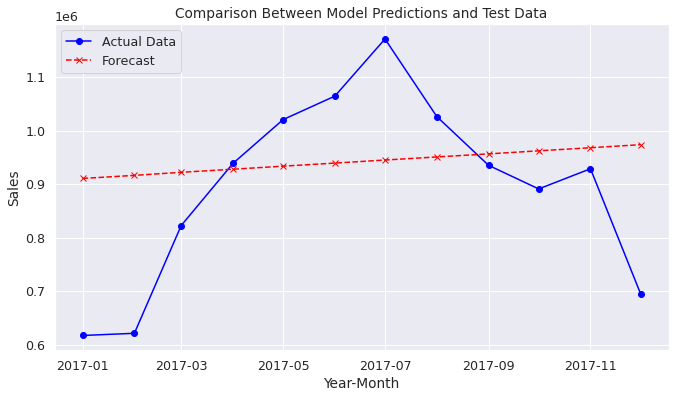

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, lr_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 2: Naive Forecast

This model states the future forecast is a constant value, equal to that of last training observation.

In [ ]:
# Building the naive forecast model 
# (propagating the last training observation into the future)
naive_pred = train[-1]*np.ones(len(test))

In [ ]:
# Evaluating model's performance metrics
rmse_score = RMSE(test, naive_pred) 
mad_score  = MAD(test, naive_pred) 
mape_score = MAPE(test, naive_pred) 

# Reporting the performance metrics
print('The naive forecast model\'s RMSE score =', round(rmse_score, 2))
print('The naive forecast model\'s MAD score =', round(mad_score, 2))
print('The naive forecast model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['Naive Forecast', :] = [rmse_score, mad_score, mape_score]

The naive forecast model's RMSE score = 285888.65
The naive forecast model's MAD score = 245758.5
The naive forecast model's MAPE score = 25.177


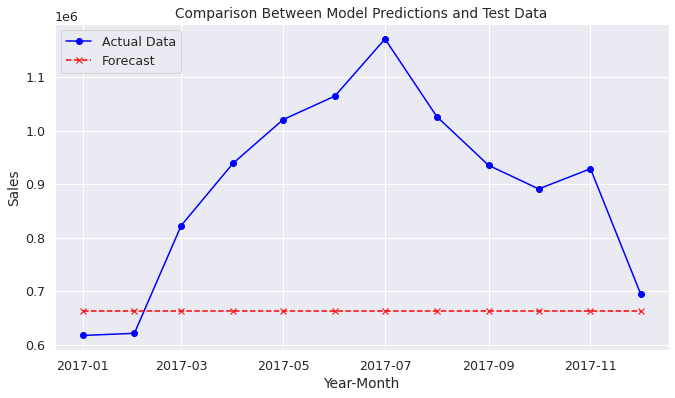

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, naive_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 3: Simple Average Forecast

In [ ]:
# Building the simple average forecast model 
# (propagating the average of training set into the future)
simple_average_pred = train.mean()*np.ones(len(test))

In [ ]:
# Evaluating model's performance metrics
rmse_score = RMSE(test, simple_average_pred) 
mad_score  = MAD(test, simple_average_pred) 
mape_score = MAPE(test, simple_average_pred) 

# Reporting the performance metrics
print('The simple average forecast model\'s RMSE score =', round(rmse_score, 2))
print('The simple average forecast model\'s MAD score =', round(mad_score, 2))
print('The simple average forecast model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['Simple Average', :] = [rmse_score, mad_score, mape_score]

The simple average forecast model's RMSE score = 209234.9
The simple average forecast model's MAD score = 187058.63
The simple average forecast model's MAPE score = 20.296


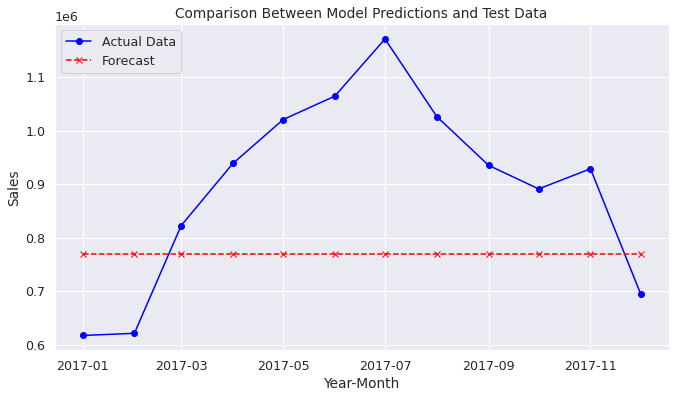

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, simple_average_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 4: Simple Exponential Smoothing (Autofit)

In [ ]:
# Suppression of warnings
import warnings
warnings.filterwarnings('ignore')

# Building the model
ses_auto = SimpleExpSmoothing(train, initialization_method = 'estimated')
ses_auto = ses_auto.fit(optimized = True)
#printses_auto
print('The level parameter of the autofit Simple Exponential Smoothing model:', ses_auto.params['smoothing_level'])

The level parameter of the autofit Simple Exponential Smoothing model: 0.995


In [ ]:
# Making predictions for the test part using the model
ses_auto_pred = ses_auto.forecast(steps = len(test))

# Evaluating model's performance metrics
rmse_score = RMSE(test, ses_auto_pred) 
mad_score  = MAD(test, ses_auto_pred) 
mape_score = MAPE(test, ses_auto_pred) 

# Reporting the performance metrics
print('The autofit Simple Exponential Smoothing model\'s RMSE score =', round(rmse_score, 2))
print('The autofit Simple Exponential Smoothing model\'s MAD score =', round(mad_score, 2))
print('The autofit Simple Exponential Smoothing model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['SES (autofit)', :] = [rmse_score, mad_score, mape_score]

The autofit Simple Exponential Smoothing model's RMSE score = 284968.45
The autofit Simple Exponential Smoothing model's MAD score = 244998.84
The autofit Simple Exponential Smoothing model's MAPE score = 25.105


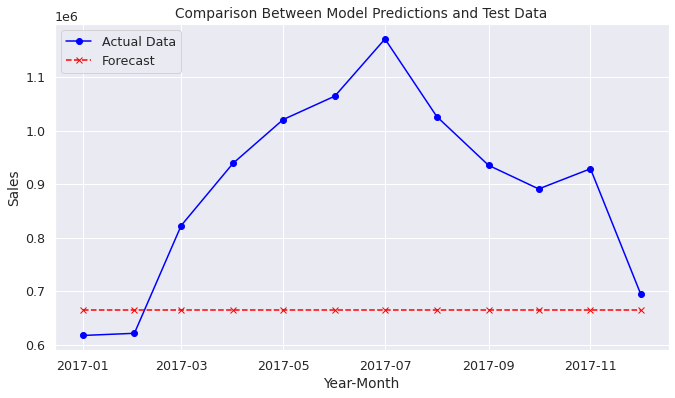

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, ses_auto_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 5: Simple Exponential Smoothing (Brute Search)

Here, since we want to avoid tuning the model on the test set, we choose the optimal hyperparameters based on the ability of the resulting model in reconstruction of the training set.

In [ ]:
# Setting the range of hyperparameters
level = np.linspace(0.01, 1, 100)

min_rmse = 1e9
# Looping over all possible combinations of hyperparameters
for alpha in level:
    # Building the model
    ses_brute = SimpleExpSmoothing(train, initialization_method = 'estimated')
    ses_brute = ses_brute.fit(smoothing_level = alpha, use_brute = True, optimized = False)
    if(RMSE(train, ses_brute.fittedvalues) < min_rmse):
        min_rmse = RMSE(train, ses_brute.fittedvalues)
        alpha_opt = alpha
    
print('The brute-search-given, optimal level parameter for the Simple Exponential Smoothing model:', alpha_opt)

The brute-search-given, optimal level parameter for the Simple Exponential Smoothing model: 1.0


In [ ]:
# Building the model using optimal hyperparameters
ses_brute = SimpleExpSmoothing(train, initialization_method = 'estimated')
ses_brute = ses_brute.fit(smoothing_level = alpha_opt, use_brute = True, optimized = False)

In [ ]:
# Making predictions for the test part using the model
ses_brute_pred = ses_brute.forecast(steps = len(test))

# Evaluating model's performance metrics
rmse_score = RMSE(test, ses_brute_pred) 
mad_score  = MAD(test, ses_brute_pred) 
mape_score = MAPE(test, ses_brute_pred) 

# Reporting the performance metrics
print('The brute-search Simple Exponential Smoothing model\'s RMSE score =', round(rmse_score, 2))
print('The brute-search Simple Exponential Smoothing model\'s MAD score =', round(mad_score, 2))
print('The brute-search Simple Exponential Smoothing model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['SES (brute search)', :] = [rmse_score, mad_score, mape_score]

The brute-search Simple Exponential Smoothing model's RMSE score = 285888.65
The brute-search Simple Exponential Smoothing model's MAD score = 245758.5
The brute-search Simple Exponential Smoothing model's MAPE score = 25.177


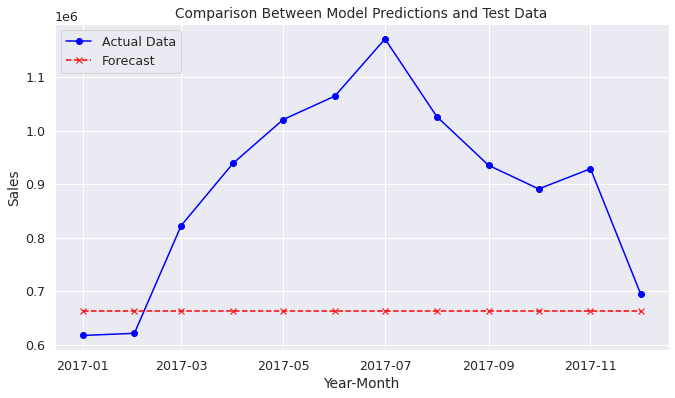

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, ses_brute_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 6: Double Exponential Smoothing (Autofit)

In [ ]:
# Building the model
des_auto = Holt(train, initialization_method = 'estimated')
des_auto = des_auto.fit(optimized = True)
print('The level parameter of the autofit Holt model:', round(des_auto.params['smoothing_level'], 3))
print('The trend parameter of the autofit Holt model:', round(des_auto.params['smoothing_trend'], 3))

The level parameter of the autofit Holt model: 0.995
The trend parameter of the autofit Holt model: 0.024


In [ ]:
# Making predictions for the test part using the model
des_auto_pred = des_auto.forecast(steps = len(test))

# Evaluating model's performance metrics
rmse_score = RMSE(test, des_auto_pred) 
mad_score  = MAD(test, des_auto_pred) 
mape_score = MAPE(test, des_auto_pred) 

# Reporting the performance metrics
print('The autofit Holt model\'s RMSE score =', round(rmse_score, 2))
print('The autofit Holt model\'s MAD score =', round(mad_score, 2))
print('The autofit Holt model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['DES (autofit)', :] = [rmse_score, mad_score, mape_score]

The autofit Holt model's RMSE score = 240528.47
The autofit Holt model's MAD score = 207737.01
The autofit Holt model's MAPE score = 21.504


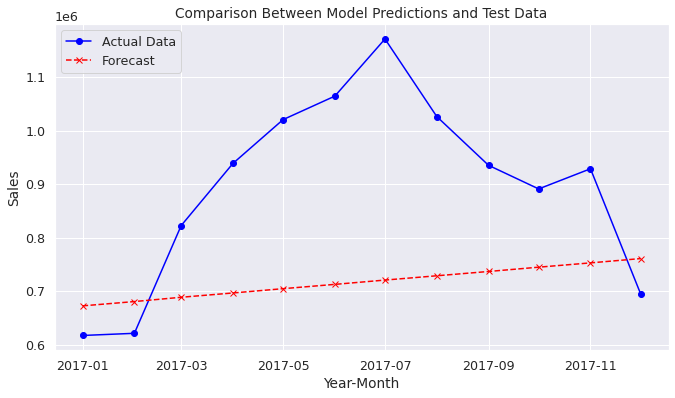

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, des_auto_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 7: Double Exponential Smoothing (Brute Search)

In order to prevent carrying out model tuning on the test set, we select the best-performing model based on its ability to minimize the reconstruction error on the training set.

In [ ]:
# Setting the range of hyperparameters
level = np.linspace(0.01, 1, 100)
trend = np.linspace(0.01, 1, 100)

min_rmse = 1e9
# Looping over all possible combinations of hyperparameters
for alpha in level:
    for beta in trend:
        # Building the model
        des_brute = Holt(train, initialization_method = 'estimated')
        des_brute = des_brute.fit(smoothing_level = alpha, smoothing_trend = beta, 
                                  use_brute = True, optimized = False)
        if(RMSE(train, des_brute.fittedvalues) < min_rmse):
            min_rmse = RMSE(train, des_brute.fittedvalues)
            alpha_opt = alpha
            beta_opt = beta
    
print('The brute-search-given, optimal level parameter for the Holt model:', alpha_opt)
print('The brute-search-given, optimal trend parameter for the Holt model:', beta_opt)

The brute-search-given, optimal level parameter for the Holt model: 1.0
The brute-search-given, optimal trend parameter for the Holt model: 0.03


In [ ]:
# Building the model using optimal hyperparameters
des_brute = Holt(train, initialization_method = 'estimated')
des_brute = des_brute.fit(smoothing_level = alpha_opt, smoothing_trend = beta_opt, 
                          use_brute = True, optimized = False)

In [ ]:
# Making predictions for the test part using the model
des_brute_pred = des_brute.forecast(steps = len(test))

# Evaluating model's performance metrics
rmse_score = RMSE(test, des_brute_pred) 
mad_score  = MAD(test, des_brute_pred) 
mape_score = MAPE(test, des_brute_pred) 

# Reporting the performance metrics
print('The brute-search Holt model\'s RMSE score =', round(rmse_score, 2))
print('The brute-search Holt Smoothing model\'s MAD score =', round(mad_score, 2))
print('The brute-search Holt model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['DES (brute search)', :] = [rmse_score, mad_score, mape_score]

The brute-search Holt model's RMSE score = 260761.78
The brute-search Holt Smoothing model's MAD score = 222832.11
The brute-search Holt model's MAPE score = 22.843


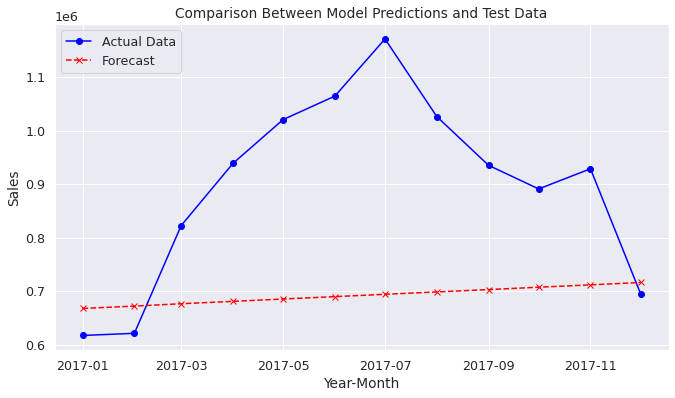

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, des_brute_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 8: Triple Exponential Smoothing (Autofit)

In [ ]:
# Building the model
tes_auto = ExponentialSmoothing(train, trend = 'additive', seasonal = 'multiplicative',
                                initialization_method = 'estimated')
tes_auto = tes_auto.fit(optimized = True)
print('The level parameter of the autofit Holt-Winters model:', round(tes_auto.params['smoothing_level'], 3))
print('The trend parameter of the autofit Holt-Winters model:', round(tes_auto.params['smoothing_trend'], 3))
print('The seasonality parameter of the autofit Holt-Winters model:', round(tes_auto.params['smoothing_seasonal'], 4))

The level parameter of the autofit Holt-Winters model: 0.571
The trend parameter of the autofit Holt-Winters model: 0.082
The seasonality parameter of the autofit Holt-Winters model: 0.0001


In [ ]:
# Making predictions for the test part using the model
tes_auto_pred = tes_auto.forecast(steps = len(test))

# Evaluating model's performance metrics
rmse_score = RMSE(test, tes_auto_pred) 
mad_score  = MAD(test, tes_auto_pred) 
mape_score = MAPE(test, tes_auto_pred) 

# Reporting the performance metrics
print('The autofit Holt-Winters model\'s RMSE score =', round(rmse_score, 2))
print('The autofit Holt-Winters model\'s MAD score =', round(mad_score, 2))
print('The autofit Holt-Winters model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['TES (autofit)', :] = [rmse_score, mad_score, mape_score]

The autofit Holt-Winters model's RMSE score = 40956.46
The autofit Holt-Winters model's MAD score = 39307.2
The autofit Holt-Winters model's MAPE score = 4.418


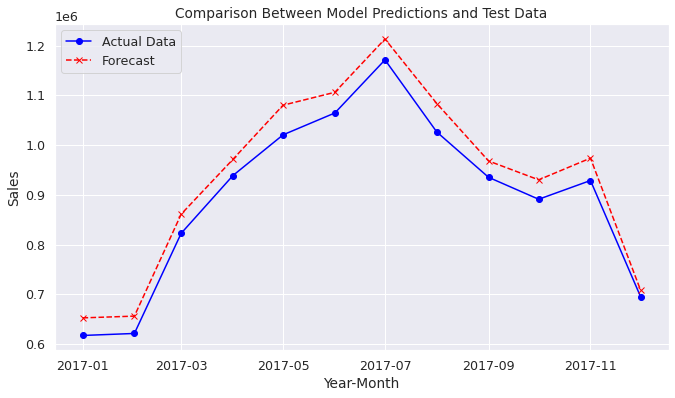

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, tes_auto_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

### Model 9: Triple Exponential Smoothing (Brute Search)

Like before, the optimal hyperparameters will be chosen based on the performance of the corresponding model on the training data.

In [ ]:
# Setting the range of hyperparameters
level = np.linspace(0.05, 1, 20)
trend = np.linspace(0.05, 1, 20)
seasonal = np.linspace(0.05, 1, 20)

min_rmse = 1e9
# Looping over all possible combinations of hyperparameters
for alpha in level:
    for beta in trend:
        for gamma in trend:
            # Building the model
            tes_brute = ExponentialSmoothing(train, trend = 'add', seasonal = 'mul', 
                                             initialization_method = 'estimated')
            tes_brute = tes_brute.fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma, 
                                      use_brute = True, optimized = False)
            if(RMSE(train, tes_brute.fittedvalues) < min_rmse):
                min_rmse = RMSE(train, tes_brute.fittedvalues)
                alpha_opt = alpha
                beta_opt = beta
                gamma_opt = gamma
    
print('The brute-search-given, optimal level parameter for the Holt-Winters model:', alpha_opt)
print('The brute-search-given, optimal trend parameter for the Holt-Winters model:', beta_opt)
print('The brute-search-given, optimal seasonality parameter for the Holt-Winters model:', gamma_opt)

The brute-search-given, optimal level parameter for the Holt-Winters model: 0.6
The brute-search-given, optimal trend parameter for the Holt-Winters model: 0.05
The brute-search-given, optimal seasonality parameter for the Holt-Winters model: 0.05


In [ ]:
# Building the model using optimal hyperparameters
tes_brute = ExponentialSmoothing(train, trend = 'additive', seasonal = 'multiplicative',
                                 initialization_method = 'estimated')
tes_brute = tes_brute.fit(smoothing_level = alpha_opt, smoothing_trend = beta_opt, smoothing_seasonal = gamma_opt, 
                          use_brute = True, optimized = False)

In [ ]:
# Making predictions for the test part using the model
tes_brute_pred = tes_brute.forecast(steps = len(test))

# Evaluating model's performance metrics
rmse_score = RMSE(test, tes_brute_pred) 
mad_score  = MAD(test, tes_brute_pred) 
mape_score = MAPE(test, tes_brute_pred) 

# Reporting the performance metrics
print('The brute-search Holt-Winters model\'s RMSE score =', round(rmse_score, 2))
print('The brute-search Holt-Winters Smoothing model\'s MAD score =', round(mad_score, 2))
print('The brute-search Holt-Winters model\'s MAPE score =', round(mape_score, 3))

# Storing the performance metrics in a dataframe
eval_metrics.loc['TES (brute search)', :] = [rmse_score, mad_score, mape_score]

The brute-search Holt-Winters model's RMSE score = 41189.54
The brute-search Holt-Winters Smoothing model's MAD score = 39617.72
The brute-search Holt-Winters model's MAPE score = 4.45


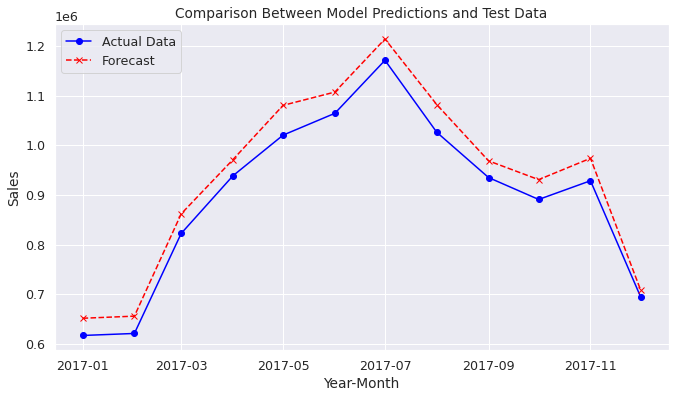

In [ ]:
# Plotting the model predictions vs. actual data
plt.figure(figsize = (11, 6));
plt.plot(test.index, test.values, color = 'blue', marker = 'o');
plt.plot(test.index, tes_brute_pred, color = 'red', linestyle = '--', marker = 'x');
plt.legend(['Actual Data', 'Forecast'], loc = 'upper left');
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.title('Comparison Between Model Predictions and Test Data');

## Selecting the Best Model

In [ ]:
eval_metrics.sort_values(by = 'RMSE')

,RMSE,MAD,MAPE (%)
TES (autofit),40956.46,39307.20,4.42
TES (brute search),41189.54,39617.72,4.45
Linear Regression,170316.83,135290.71,17.49
Simple Average,209234.90,187058.63,20.30
DES (autofit),240528.47,207737.01,21.50
DES (brute search),260761.78,222832.11,22.84
SES (autofit),284968.45,244998.84,25.11
Naive Forecast,285888.65,245758.50,25.18
SES (brute search),285888.65,245758.50,25.18


#### Observations:

The ***autofit Triple Exponential Smoothing (Holt-Winters) model*** has the best performance, according to all performance metrics.

## Prediction of Future via the Best Model

We use the full data to predict one year into the future (2018).

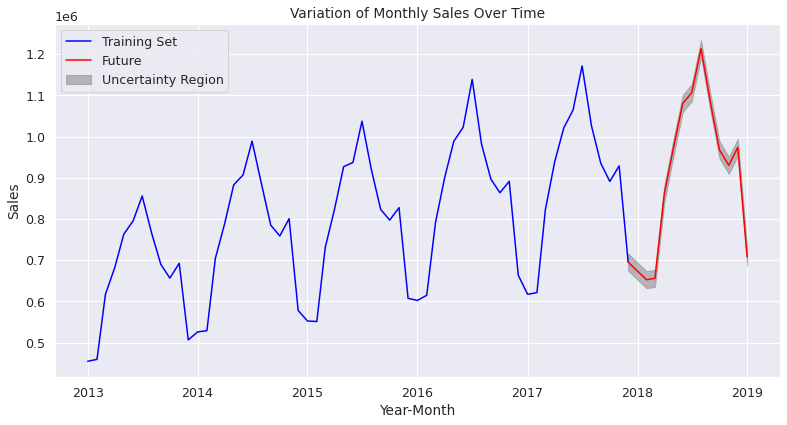

In [ ]:
# Building the best-performing model
best_model = ExponentialSmoothing(train, trend = 'add', seasonal = 'mul', 
                                  initialization_method = 'estimated')
best_model = best_model.fit(optimized = True)

# Defining the range of future forecast
future_range = pd.date_range(start = '1/1/2018', periods = 12, freq = 'M')
future_range = list(future_range)
future_range.insert(0, df.index[-1])

# Forecasting the future (2018)
future_pred = best_model.forecast(12)
future_pred = list(future_pred)
future_pred.insert(0, df['Sales'][-1])

# Calculating the region of uncertainty (95% confidence interval)
lower_bound = future_pred - 1.96*np.std(best_model.resid)
upper_bound = future_pred + 1.96*np.std(best_model.resid)

# Plotting the provided dataset along with future predictions
plt.figure(figsize = (13, 6.5));
plt.plot(df.index, df['Sales'], color = 'blue');
plt.plot(future_range, future_pred, color = 'red');
plt.fill_between(x = future_range, y1 = lower_bound, y2 = upper_bound, color = 'grey', alpha = 0.5)
plt.xlabel('Year-Month');
plt.ylabel('Sales');
plt.legend(['Training Set', 'Future', 'Uncertainty Region'], loc = 'upper left');
plt.title('Variation of Monthly Sales Over Time');